In [1]:
import pickle
import numpy as np
import os

from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

SEED = 42

In [2]:
remove_stop_words = False # to remove stop words or not

In [3]:
wv_path = ['./data/train_data/train', './data/test_data/test', './data/dev_data/dev']

if remove_stop_words:
    with open(wv_path[0] + f'_onehot_sst2_nonstop.pkl', 'rb') as f:
        X_train_tensor, y_train = pickle.load(f)
    with open(wv_path[2] + f'_onehot_sst2_nonstop.pkl', 'rb') as f:
        X_dev_tensor, y_dev = pickle.load(f)
else:
    with open(wv_path[0] + f'_onehot_sst2.pkl', 'rb') as f:
        X_train_tensor, y_train = pickle.load(f)
    with open(wv_path[2] + f'_onehot_sst2.pkl', 'rb') as f:
        X_dev_tensor, y_dev = pickle.load(f)

In [4]:
wv_num = X_train_tensor.shape[1]

In [5]:
print(f"Shape of training data {[X_train_tensor.shape[i] for i in range(3)]}")
print(f"Shape of training data {[X_dev_tensor.shape[i] for i in range(3)]}")

Shape of training data [67349, 69, 268]
Shape of training data [872, 69, 268]


In [6]:
# process labels
labels = list(set(y_train + y_dev))
label_num = len(labels)
print(f"Number of label types: {label_num}")

Number of label types: 2


In [7]:
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float)
        self.y =torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

def initialize_loader(X_train_tensor, X_dev_tensor, y_train, y_dev, batch_size=64):
    # no need to do the scale since original wv already did
    train_data = CustomDataset(X_train_tensor, y_train)
    dev_data = CustomDataset(X_dev_tensor, y_dev)

    # convert to DataLoader for batch processing and shuffling
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
    dev_dataloader = DataLoader(dev_data, batch_size=batch_size, shuffle=False)
    for inputs, targets in dev_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
    return train_dataloader, dev_dataloader

train_dataloader, test_dataloader = initialize_loader(X_train_tensor, X_dev_tensor, y_train, y_dev)

C:\Users\Chihao Shen\AppData\Local\Temp\ipykernel_8376\2952365461.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float)


In [8]:
# model
class CNN(nn.Module):
    def __init__(self, dim_input, dim_out):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=dim_input, out_channels=1024, kernel_size=7, stride=1),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=7, stride=1),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1),
            nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1),
            nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1),
            nn.MaxPool1d(kernel_size=3, stride=3),
            nn.Flatten(),

            nn.Linear(7168, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, dim_out),
            nn.Softmax()
        )

        # para initialization

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
torch.manual_seed(SEED)
dim_in = wv_num
dim_out = label_num
lr = 0.0001
model = CNN(dim_in, dim_out)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
# training
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    optimizer.zero_grad()
    train_loss, correct_num = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        model.eval()
        
        train_loss += loss.item() * X.size(0)
        correct_num += (torch.eq(torch.argmax(pred, dim=1), y)).type(torch.float).sum().item()

    train_loss /= size
    train_acc = correct_num / size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct_num = 0, 0
    model.eval()  # inform no dropout

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item() * X.size(0)
            correct_num += (torch.eq(torch.argmax(pred, dim=1), y)).type(torch.float).sum().item()

    test_loss /= size
    test_acc = correct_num / size
    return test_loss, test_acc
        

In [11]:
patience = 10
best_test_loss = np.Inf
best_test_acc = 0
train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
no_epochs = 100

# start training
for epoch in tqdm(range(no_epochs)):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)

    # early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_without_improvement = 0
        best_model = model.state_dict()
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            print(f'Best test loss: {best_test_loss}')
            print(f'Best test accuracy: {best_test_acc}')
            break


    print(f"Epoch {epoch+1}, train_loss {train_loss:>7f} train_acc {train_acc:>4f}, test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")
os.makedirs("./model", exist_ok=True)
torch.save(best_model, './model/CNN_onehot_model.pth')

  0%|          | 0/100 [00:00<?, ?it/s]e:\git\SC4001\Project\venv\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  1%|          | 1/100 [00:53<1:27:52, 53.25s/it]

Epoch 1, train_loss 0.671050 train_acc 0.579697, test_loss 0.695254, test_acc 0.565367


  2%|▏         | 2/100 [01:48<1:29:11, 54.61s/it]

Epoch 2, train_loss 0.569457 train_acc 0.723366, test_loss 0.588622, test_acc 0.708716


  3%|▎         | 3/100 [02:44<1:28:52, 54.97s/it]

Epoch 3, train_loss 0.495706 train_acc 0.807154, test_loss 0.591498, test_acc 0.696101


  4%|▍         | 4/100 [03:40<1:28:31, 55.33s/it]

Epoch 4, train_loss 0.455932 train_acc 0.849872, test_loss 0.559062, test_acc 0.731651


  5%|▌         | 5/100 [04:34<1:27:03, 54.98s/it]

Epoch 5, train_loss 0.429691 train_acc 0.879092, test_loss 0.586046, test_acc 0.715596


  6%|▌         | 6/100 [05:28<1:25:23, 54.51s/it]

Epoch 6, train_loss 0.416683 train_acc 0.893554, test_loss 0.594981, test_acc 0.707569


  7%|▋         | 7/100 [06:21<1:24:11, 54.32s/it]

Epoch 7, train_loss 0.404557 train_acc 0.904898, test_loss 0.616937, test_acc 0.686927


  8%|▊         | 8/100 [07:20<1:25:25, 55.71s/it]

Epoch 8, train_loss 0.399715 train_acc 0.910956, test_loss 0.560475, test_acc 0.743119


  9%|▉         | 9/100 [08:19<1:26:00, 56.71s/it]

Epoch 9, train_loss 0.392623 train_acc 0.918796, test_loss 0.584037, test_acc 0.717890


 10%|█         | 10/100 [09:18<1:26:13, 57.48s/it]

Epoch 10, train_loss 0.388914 train_acc 0.922419, test_loss 0.589726, test_acc 0.717890


 11%|█         | 11/100 [10:16<1:25:35, 57.70s/it]

Epoch 11, train_loss 0.386368 train_acc 0.925225, test_loss 0.588388, test_acc 0.716743


 12%|█▏        | 12/100 [11:21<1:27:50, 59.89s/it]

Epoch 12, train_loss 0.381516 train_acc 0.930006, test_loss 0.610885, test_acc 0.697248


 13%|█▎        | 13/100 [12:22<1:27:12, 60.15s/it]

Epoch 13, train_loss 0.384536 train_acc 0.927170, test_loss 0.580231, test_acc 0.724771


 13%|█▎        | 13/100 [13:21<1:29:23, 61.65s/it]

Early stopping after 14 epochs
Best test loss: 0.559062366091877
Best test accuracy: 0.7431192660550459


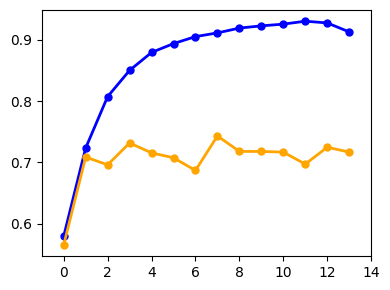

In [12]:
import matplotlib.pyplot as plt

epochs = [i*2 for i in range(0, len(train_acc_)//2 + 1)]
plt.figure(figsize=(4, 3))
plt.plot(train_acc_, marker='o', linestyle='-', color='blue', label='Train', linewidth=2, markersize=5)
plt.plot(test_acc_, marker='o', linestyle='-', color='orange', label='Test', linewidth=2, markersize=5)
# plt.ylabel('Accuracy', fontsize=12)
# plt.xlabel('Epoch', fontsize=12)
plt.xticks(epochs)
plt.xlim(-1, len(train_acc_)) 
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.show()

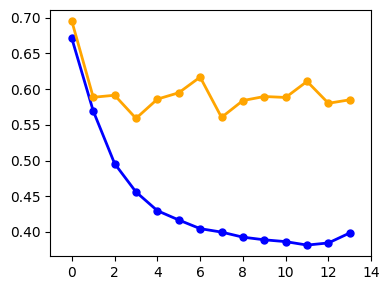

In [13]:
epochs = [i*2 for i in range(0, len(train_acc_)//2 + 1)]
plt.figure(figsize=(4, 3))
plt.plot(train_loss_, marker='o', linestyle='-', color='blue', label='Train', linewidth=2, markersize=5)
plt.plot(test_loss_, marker='o', linestyle='-', color='orange', label='Test', linewidth=2, markersize=5)
# plt.ylabel('Loss', fontsize=12)
# plt.xlabel('Epoch', fontsize=12)
plt.xticks(epochs)
plt.xlim(-1, len(train_acc_)) 
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.show()